<a href="https://colab.research.google.com/github/kynk94/11th_Project/blob/master/dance/training_by_%EC%84%9C%EC%84%9D%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os

import torch
import torch.utils.data as data

from PIL import Image

class ImageData(data.Dataset):
    
    def __init__(self, root_origin, root_pose, transform=None, loader=None):
        def convert_str2int(path):
            li_int = []
            for filename in os.listdir(path):
                if filename.endswith('.png'):
                    li_int.append(str(filename.split('.')[0]))

            return sorted(li_int)
        
        li_origin = convert_str2int(root_origin)
        li_pose = convert_str2int(root_pose)
        
        #assert len(li_origin) == len(li_pose)
        
        self.origin_set = [root_origin + '/' + str(file_origin) + '.png' for file_origin in li_origin]
        self.pose_set = [root_pose + '/' + str(file_pose) + '.png' for file_pose in li_pose]
        
        self.transform = transform
        
        return None
        
    def __getitem__(self, index):
        path_img_origin_pre = self.origin_set[index]
        path_img_pose_pre = self.pose_set[index]
        
        if index == len(self.origin_set)-1:
          path_img_origin_cur = self.origin_set[index]
          path_img_pose_cur = self.pose_set[index]
        else:
          path_img_origin_cur = self.origin_set[index+1]
          path_img_pose_cur = self.pose_set[index+1]
        
        img_origin_pre = self.transform(Image.open(path_img_origin_pre).convert('RGB'))
        img_pose_pre = self.transform(Image.open(path_img_pose_pre).convert('RGB'))

        img_origin_cur = self.transform(Image.open(path_img_origin_cur).convert('RGB'))
        img_pose_cur = self.transform(Image.open(path_img_pose_cur).convert('RGB'))
        
        return torch.cat([img_origin_pre, img_pose_pre]),  torch.cat([img_origin_cur, img_pose_cur])
    
    def __len__(self):
        return len(self.origin_set)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as spectral_norm

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_block=9, norm_layer=nn.InstanceNorm2d, padding_type = 'reflect'):
        super(Generator, self).__init__()

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2

        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]


        mult = 2 ** n_downsampling
        for i in range(n_block):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult /2), kernel_size=3, stride=2, padding = 1, output_padding=1, bias=True),
                      norm_layer(int(ngf*mult/2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
                  nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, norm_layer)

    def build_conv_block(self, dim, norm_layer):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, padding = 0, bias = True),
                       norm_layer(dim),
                       nn.ReLU(True)]
        return nn.Sequential(*conv_block)
    def forward(self, x):
        output = x + self.conv_block(x)
        return output

class MultiscaleDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf = 64, n_layer =3, norm_layer = nn.InstanceNorm2d, num_D=3, getIntermFeat = False):
        super(MultiscaleDiscriminator, self).__init__()
        self.num_D = num_D
        self.n_layer = n_layer
        self.getIntermFeat = getIntermFeat
        self.downsample = nn.AvgPool2d(3, stride=2, padding= [1,1], count_include_pad=False)

        for i in range(num_D):
            netD = NLayerDiscriminator(input_nc, ndf, n_layer, norm_layer, getIntermFeat=getIntermFeat)
            if getIntermFeat:
                for j in range(n_layer+2):
                    setattr(self, 'scale' +str(i)+'_layer' + str(j), getattr(netD, 'model'+str(j)))
            else:
                setattr(self, 'layer'+str(i), netD.model)

    def singleD_forward(self, model, input):
        if self.getIntermFeat:
            result = [input]
            for i in range(len(model)):
                result.append(model[i](result[-1]))

            return result[1:]
        else:
            return [model(input)]

    def forward(self, input):
        num_D = self.num_D
        result = []
        input_downsampled = input

        for i in range(num_D):
            if self.getIntermFeat:
                model = [getattr(self, 'scale'+str(num_D -1 -i)+'_layer'+str(j)) for j in range(self.n_layer+2)]
            else:
                model = [getattr(self, 'layer'+str(num_D -1 -i))]

            result.append(self.singleD_forward(model, input_downsampled))

            if i != (num_D-1):
                input_downsampled = self.downsample(input_downsampled)

        return result

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf = 64, n_layers=3, norm_layer = nn.InstanceNorm2d, getIntermFeat = False):
        super(NLayerDiscriminator, self).__init__()
        self.n_layer = n_layers
        self.getIntermFeat = getIntermFeat

        sequence = [[spectral_norm(nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=2)), nn.LeakyReLU(0.2, True)]]

        nf = ndf
        for n in range(1, n_layers):
            nf_prev = nf
            nf = min(nf*2, 512)
            sequence += [[spectral_norm(nn.Conv2d(nf_prev, nf, kernel_size=4, stride=2, padding=2)), norm_layer(nf), nn.LeakyReLU(0.2, True)]]

        nf_prev = nf
        nf = min(nf*2, 512)
        sequence += [[spectral_norm(nn.Conv2d(nf_prev, nf, kernel_size = 4, stride = 1, padding = 2)), norm_layer(nf), nn.LeakyReLU(0.2, True)]]
        sequence += [[spectral_norm(nn.Conv2d(nf, 1, kernel_size=4, stride = 1, padding = 2))]]

        if getIntermFeat:
            for n in range(len(sequence)):
                setattr(self, 'model'+str(n), nn.Sequential(*sequence[n]))
        else:
            sequence_stream = []
            for n in range(len(sequence)):
                sequence_stream += sequence[n]
            self.model = nn.Sequential(*sequence_stream)

    def forward(self, input):
        if self.getIntermFeat:
            res = [input]
            for n in range(self.n_layer+2):
                model = getattr(self, 'model'+str(n))
                res.append(model(res[-1]))
            return res[1:]
        else:
            return self.model(input)

from torchvision import models
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)
        h_relu3 = self.slice3(h_relu2)
        h_relu4 = self.slice4(h_relu3)
        h_relu5 = self.slice5(h_relu4)
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out






In [0]:
import torch
import torch.nn as nn
#from model_dance import Vgg19


class GANLoss(nn.Module):
    def __init__(self, gan_mode, device, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.target_real_label = target_real_label
        self.target_fake_label = target_fake_label
        self.device = device

        self.gan_mode = gan_mode
        self.Tensor = torch.FloatTensor

        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'wgangp':
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.Tensor(prediction.size()).fill_(self.target_real_label)
        else:
            target_tensor = self.Tensor(prediction.size()).fill_(self.target_fake_label)
        return target_tensor

    def __call__(self, prediction, target_is_real):
        if self.gan_mode in ['lsgan']:
            if isinstance(prediction[0], list):
                loss = 0
                for pred_i in prediction:
                    pred = pred_i[-1]
                    target_tensor = self.get_target_tensor(pred, target_is_real)
                    loss += self.loss(pred, target_tensor.to(self.device))
                return loss
            else:
                target_tensor = self.get_target_tensor(input[-1], target_is_real)
                return self.loss(input[-1], target_tensor.to(self.device))

        elif self.gan_mode == 'wgangp':
            if self.gan_mode == 'wgangp':
                if target_is_real:
                    loss = -prediction.mean()
                else:
                    loss = prediction.mean()
        return loss


class VGGLoss(nn.Module):
    def __init__(self, device):
        super(VGGLoss, self).__init__()
        self.vgg = Vgg19().to(device)
        self.criterion = nn.L1Loss()
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]

    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())
        return loss


class FMLoss(nn.Module):
    def __init__(self, device, num_D=3, n_layers=3):
        super(FMLoss, self).__init__()
        self.num_D = num_D
        self.n_layers = n_layers
        self.criterion = nn.L1Loss()
        self.feat_weight = (4.0 / n_layers + 1)
        self.D_weight = 1.0 / num_D

    def forward(self, fake, real):
        loss = 0
        for i in range(self.num_D):
            for j in range(len(fake[i]) - 1):
                loss += self.D_weight * self.feat_weight * \
                        self.criterion(fake[i][j], real[i][j].detach())
        return loss

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [0]:
G = Generator(6, 3).to(device)

In [0]:
D = MultiscaleDiscriminator(12, getIntermFeat=True).to(device)

In [0]:
import torch.utils.data as data

In [0]:
from PIL import Image

In [0]:
imageData = ImageData('/gdrive/My Drive/source/target/test_img', '/gdrive/My Drive/source/target/test_label_ori', transform = transform)

In [0]:
DataLoader = data.DataLoader(imageData, batch_size = 1)
gan_loss = GANLoss('lsgan', device)
vgg_loss = VGGLoss(device)
fm_loss = FMLoss(device)
# optimizaer
optim_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
def imshow(img, title, size=(5, 5)):
    npimg = img.numpy()
    fig = plt.figure(figsize=size)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [0]:
num_epoch = 10
from tqdm import tnrange
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

Epoch [0/10], Iter [1000/1000], D_loss: 0.0332, G_loss: 6.2887


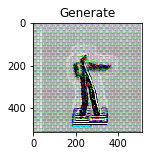

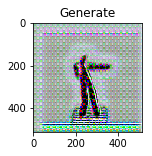

Epoch [1/10], Iter [1000/1000], D_loss: 0.0292, G_loss: 6.2420


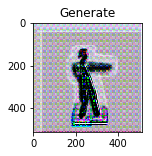

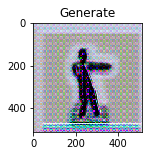

Epoch [2/10], Iter [1000/1000], D_loss: 0.0072, G_loss: 6.1373


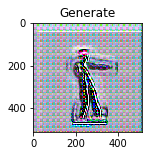

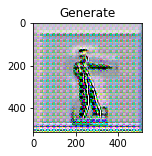

Epoch [3/10], Iter [1000/1000], D_loss: 0.0083, G_loss: 5.7545


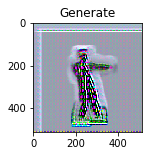

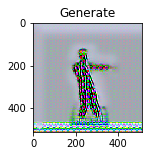

Epoch [4/10], Iter [1000/1000], D_loss: 0.0038, G_loss: 5.8728


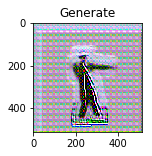

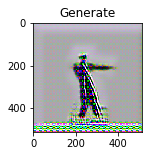

Epoch [5/10], Iter [1000/1000], D_loss: 0.0031, G_loss: 6.0584


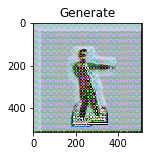

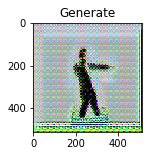

Epoch [6/10], Iter [1000/1000], D_loss: 0.0021, G_loss: 5.7327


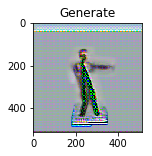

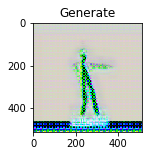

Epoch [7/10], Iter [1000/1000], D_loss: 0.0174, G_loss: 6.3539


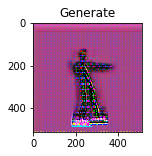

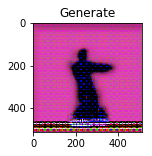

Epoch [8/10], Iter [1000/1000], D_loss: 0.0026, G_loss: 6.5279


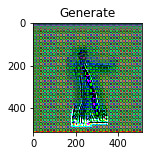

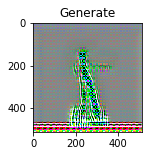

Epoch [9/10], Iter [1000/1000], D_loss: 0.0046, G_loss: 6.0148


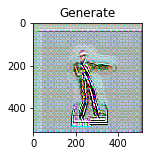

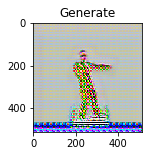

In [0]:
for epoch in tnrange(num_epoch):
    total_batch = len(imageData)

    for idx, (set_pre, set_cur) in tqdm_notebook(enumerate(DataLoader)):
        D.train()
        G.train()
        
        set_pre = set_pre.to(device)
        set_cur = set_cur.to(device)
        
        # fake2
        # fake_first 
        img_zero = torch.zeros((set_cur.size(0), 3, set_cur.size(2), set_cur.size(3))).to(device)
        img_fake_pre = G(torch.cat([img_zero, set_pre[:,3:,:,:]], dim=1))
        img_fake_cur = G(torch.cat([img_fake_pre.detach(), set_cur[:,3:,:,:]], dim=1))
        
        
        # Fake Detection and Loss
        output_fake = D(torch.cat([img_fake_pre.detach(), set_pre[:,3:,:,:], img_fake_cur.detach(), set_cur[:,3:,:,:]], dim=1))
        D_loss_fake = gan_loss(output_fake, False)
        
        # Real Detection and Loss
        output_real = D(torch.cat([set_pre, set_cur], dim=1))
        D_loss_real = gan_loss(output_real, True)
        
        # GAN loss 
        output_fake_g = D(torch.cat([img_fake_pre, set_pre[:,3:,:,:], img_fake_cur, set_cur[:,3:,:,:]], dim=1))
        G_loss = gan_loss(output_fake_g, True)
        
        # VGG loss
        VGG_loss_cur = vgg_loss(img_fake_cur, set_cur[:,:3,:,:])
        VGG_loss_pre = vgg_loss(img_fake_pre, set_pre[:,:3,:,:])
        
        # Feature Matching loss
        FM_loss = fm_loss(output_fake_g, output_real)
        
        D_loss_total = (D_loss_fake + D_loss_real) * 0.5
        G_loss_total = G_loss + 1 * (VGG_loss_cur + VGG_loss_pre) + 1 * FM_loss

        optim_G.zero_grad()
        G_loss_total.backward()
        optim_G.step()
        
        optim_D.zero_grad()
        D_loss_total.backward()
        optim_D.step()
        
        if (idx+1) % 1000 == 0:
            print('Epoch [%d/%d], Iter [%d/%d], D_loss: %.4f, G_loss: %.4f'
                 %(epoch, num_epoch, idx+1, total_batch, D_loss_total.item(), G_loss_total.item()))
            
            G.eval()
            D.eval()

            ## check Image
            img =  G(torch.cat([img_zero[:1,:,:,:], set_pre[:1,3:,:,:]], dim=1))
            img2 = G(torch.cat([img, set_cur[:1,3:,:,:]], dim=1))
            imshow(torchvision.utils.make_grid(img.squeeze().data.cpu(), normalize=True), "Generate", size=(2,2))
            imshow(torchvision.utils.make_grid(img2.squeeze().data.cpu(), normalize=True), "Generate", size=(2,2))
            
            ## save
            torch.save(G.state_dict(), '/gdrive/My Drive/source/G_{:03d}_{:03d}.pkl'.format(epoch+1, idx))
            torch.save(D.state_dict(), '/gdrive/My Drive/source/D_{:03d}_{:03d}.pkl'.format(epoch+1, idx))

In [0]:
device

'cuda'

In [0]:
len(imageData.origin_set)

1000